# Classification

This week's tutorial is about classification. In particular, we will use Gaussian Class Conditionals (GCCs) to classify one-dimensional and 2-dimensional data. 

To simplify things, let’s assume that the prior class probabilities are equal.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import pandas as pd
from scipy.stats import gaussian_kde

### Classifying 1D data

Before classifying 2D data, let's make sure we understand how a GCC would work in 1D.

We will start by randomizing some data from normal distributions

In [2]:
# Lets define a normal distribution for two classes
mean1 = 2.0
std_dev1 = 1.0
mean2 = 7.0
std_dev2 = 1.5

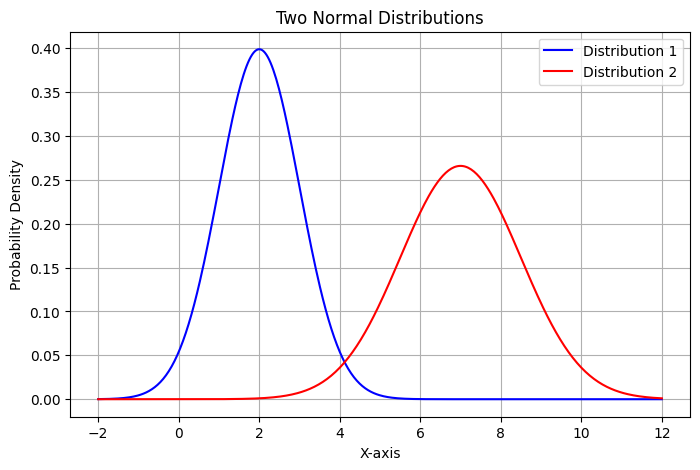

In [3]:
# Lets also plot the PDFs to get an idea of how they look
x = np.linspace(-2, 12, 400)
pdf1 = norm.pdf(x, loc=mean1, scale=std_dev1)
pdf2 = norm.pdf(x, loc=mean2, scale=std_dev2)
plt.figure(figsize=(8, 5))
plt.plot(x, pdf1, label='Distribution 1', color='blue')
plt.plot(x, pdf2, label='Distribution 2', color='red')
plt.xlabel('X-axis')
plt.ylabel('Probability Density')
plt.title('Two Normal Distributions')
plt.legend()
plt.grid(True)
plt.show()

In [4]:
# Lets now sample points from these classes
np.random.seed(21)
num_samples = 100
data1 = np.random.normal(mean1, std_dev1, num_samples).reshape(-1, 1)
data2 = np.random.normal(mean2, std_dev2, num_samples).reshape(-1, 1)


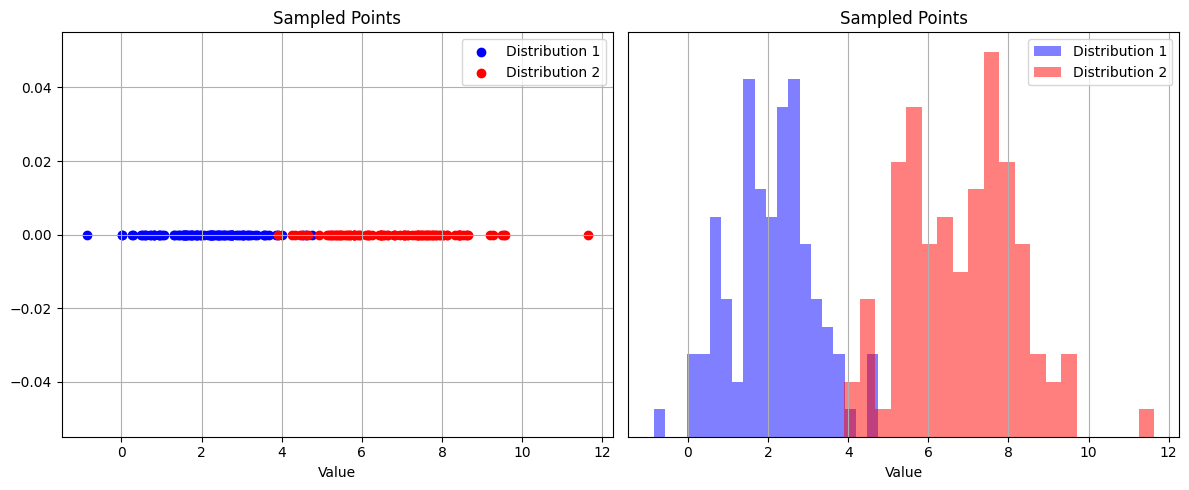

In [5]:
# Lets also plot those points
# Create a side-by-side subplot
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Plot the scatter plot on the first subplot
axes[0].scatter(data1, np.zeros_like(data1), label='Distribution 1', color='blue')
axes[0].scatter(data2, np.zeros_like(data2), label='Distribution 2', color='red')
axes[0].set_xlabel('Value')
axes[0].set_title('Sampled Points')
axes[0].legend()
axes[0].grid(True)

# Plot the histograms on the second subplot
axes[1].hist(data1, bins=20, alpha=0.5, color='blue', label='Distribution 1')
axes[1].hist(data2, bins=20, alpha=0.5, color='red', label='Distribution 2')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Sampled Points')
axes[1].legend()
axes[1].grid(True)

# Show
axes[1].axes.get_yaxis().set_visible(False)
plt.tight_layout()
plt.show()

Now that we've sampled data, lets try to code our GCC. 

The following decision function represents the log of ratio (12) provided in the lecture notes. As such, its sign determines the class of x.
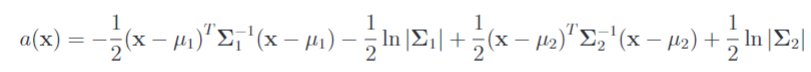

In [6]:
# TODO: Use numpy methods to compute important values
# https://numpy.org/doc/stable/reference/routines.statistics.html 

# Calculate the mean and variance for class 1
mean1_estimated = np.average(data1)
variance1_estimated = np.var(data1)

# Calculate the mean and variance for class 2
mean2_estimated = np.average(data2)
variance2_estimated = np.var(data2)

In [7]:
print(mean1_estimated, variance1_estimated, mean2_estimated, variance2_estimated)

2.104420460658756 1.1366360476019925 6.844367402614129 1.9737460256556545


In [8]:
def classify1D(x, mean1, cov1, mean2, cov2):
    # TODO: Complete function
    # Return 1 or -1, where 1 means dist1 and -1 means dist2
    invcov1 = np.linalg.inv(cov1)
    invcov2 = np.linalg.inv(cov2)

    a = -0.5 * (x - mean1).T @ invcov1 @ (x - mean1) - 0.5 * np.log(np.linalg.det(invcov1))\
    + 0.5 * (x - mean2).T @ invcov2 @ (x - mean2) - 0.5 * np.log(np.linalg.det(invcov2))   

    # print(a) 
    belongc1, belongc2 = 1, -1
    return belongc1 if a >= 0 else belongc2

In [9]:
prediction1 = np.apply_along_axis(classify1D, axis=1, arr=data1, 
                    mean1=mean1_estimated, cov1=[[variance1_estimated]], 
                    mean2=mean2_estimated, cov2=[[variance2_estimated]])

prediction2 = np.apply_along_axis(classify1D, axis=1, arr=data2, 
                    mean1=mean1_estimated, cov1=[[variance1_estimated]], 
                    mean2=mean2_estimated, cov2=[[variance2_estimated]])

print("Misclassified", np.count_nonzero(prediction1 - 1), "points from distribution 1")
print("Misclassified", np.count_nonzero(prediction2 + 1), "points from distribution 2")

Misclassified 3 points from distribution 1
Misclassified 2 points from distribution 2


### Classifying 2D data

Now that we understand the basics, lets try to visualize 2D data.

In [10]:
df = pd.read_csv('iris_data.csv')

# Extract the data and labels
data = df[['Feature1', 'Feature2']].to_numpy()
labels = df['Label'].to_numpy()

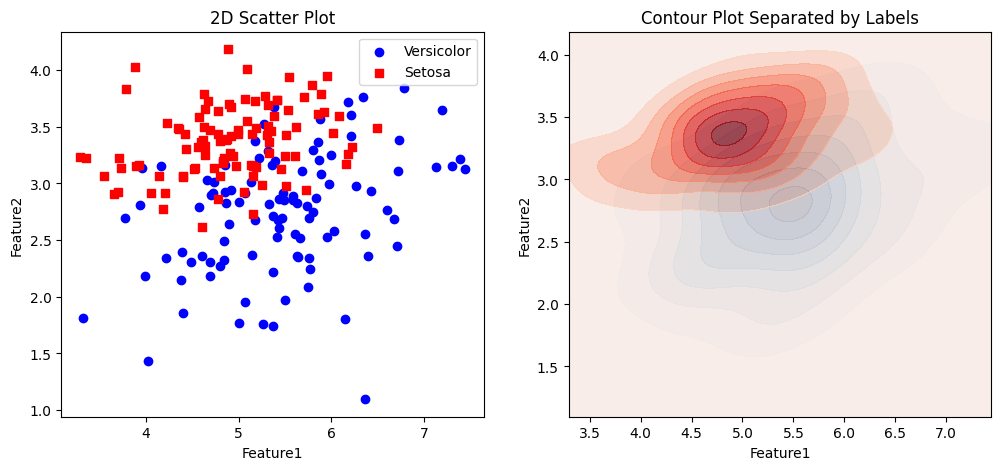

In [11]:
# Visualize 2D
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

# First subplot: 2D scatter plot
ax1.scatter(data[labels == 1][:, 0], data[labels == 1][:, 1], c='blue', label='Versicolor', marker='o')
ax1.scatter(data[labels == -1][:, 0], data[labels == -1][:, 1], c='red', label='Setosa', marker='s')
ax1.set_title('2D Scatter Plot')
ax1.set_xlabel('Feature1')
ax1.set_ylabel('Feature2')
ax1.legend()

# Second subplot: Better way to visualize the data
x, y = data[:, 0], data[:, 1]
versicolor_data = data[labels == 1]
setosa_data = data[labels == -1]

kde_versicolor = gaussian_kde(versicolor_data.T)
kde_setosa = gaussian_kde(setosa_data.T)
xi, yi = np.mgrid[x.min():x.max():100j, y.min():y.max():100j]
zi_versicolor = kde_versicolor(np.vstack([xi.flatten(), yi.flatten()]))
zi_setosa = kde_setosa(np.vstack([xi.flatten(), yi.flatten()]))

ax2.contourf(xi, yi, zi_versicolor.reshape(xi.shape), cmap='Blues', alpha=0.7)
ax2.contourf(xi, yi, zi_setosa.reshape(xi.shape), cmap='Reds', alpha=0.7)
ax2.set_title('Contour Plot Separated by Labels')
ax2.set_xlabel('Feature1')
ax2.set_ylabel('Feature2')

# Show the plots
plt.show()

Finally, let's code our 2D GCC for the 2 classes

In [23]:
def trainGCC(data, labels):
    # TODO: Complete function
    data_class1 = data[labels == 1]
    data_class2 = data[labels == -1]

    # Calculate the means for each class
    mean1 = np.average(data_class1, axis=0)
    mean2 = np.average(data_class2, axis=0)

    # Calculate the covariance matrix for each class
    cov1 = np.cov(data_class1, rowvar=False)
    cov2 = np.cov(data_class2, rowvar=False)
    
    return mean1, cov1, mean2, cov2

In [24]:
def classify2D(x, mean1, cov1, mean2, cov2):
    # TODO: Complete function
    invcov1 = np.linalg.inv(cov1)
    invcov2 = np.linalg.inv(cov2)

    # Calculate the discriminant values for each class #
    disc1 = -0.5 * (x - mean1).T @ invcov1 @ (x - mean1) - 0.5 * np.log(np.linalg.det(cov1))
    disc2 = -0.5 * (x - mean2).T @ invcov2 @ (x - mean2) - 0.5 * np.log(np.linalg.det(cov2))

    # Compare discriminant values to classify x as belonging to c1 or c2 #
    if disc1 > disc2:
        return 1
    else:
        return -1

In [25]:
mean1, cov1, mean2, cov2 = trainGCC(data, labels)
predictions = np.apply_along_axis(classify2D, axis=1, arr=data, 
                    mean1=mean1, cov1=cov1, mean2=mean2, cov2=cov2)

print("Misclassified", np.count_nonzero(predictions - labels), "out of", len(data), "points")

Misclassified 35 out of 200 points


In [26]:
mean1, cov1, mean2, cov2

(array([5.46690361, 2.74629572]),
 array([[0.69851237, 0.15832405],
        [0.15832405, 0.28198238]]),
 array([4.92124537, 3.37267095]),
 array([[0.45266213, 0.06043761],
        [0.06043761, 0.09604162]]))